<a href="https://colab.research.google.com/github/peterhaasme/nc_covid19_dashboard/blob/max_text/nc_covid19_dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Globals

##Import Libraries



In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
from datetime import datetime, timedelta 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from PIL import Image
import requests

##Create dataframes

In [2]:
df = pd.read_json('https://covidtracking.com/api/v1/states/nc/daily.json') # Read in NC time series from Covid Tracking Project
df = df.fillna(0) # Replace NaN with 0
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d') # Convert date to datetime object
df['date_col'] = df['date'].dt.strftime('%b %d, %Y') # Create date column for plotly table
df = df.iloc[::-1].reset_index(drop=True) # Order DataFrame by chronological ascending
df_col_names = list(df.columns) # Create list of column names for plots
df['hospitalized_avg'] = df['hospitalizedCurrently'].rolling(14).mean().round() # Add 'hospitalized' 14d moving average column
df['new_case_avg'] = df['positiveIncrease'].rolling(14).mean().round() # Add 14d moving average column for new cases
df['percent_pos'] = (df['positiveIncrease'] / df['totalTestResultsIncrease'] * 100).round(1) # Calculate positive test percentage
df['avg_percent_pos'] = df['percent_pos'].rolling(14).mean().round(1) # Add 14d moving average column for percent positive
df['avg_daily_tests'] = df['totalTestResultsIncrease'].rolling(14).mean().round() # Add column for 14d total test moving average

In [73]:
df['avg_percent_pos'].tail(14)

95     7.2
96     7.3
97     7.4
98     7.5
99     7.5
100    7.6
101    7.6
102    7.7
103    7.4
104    7.5
105    7.5
106    7.4
107    7.4
108    7.3
Name: avg_percent_pos, dtype: float64

##Functions

In [3]:
# Find date of maximum incidence. Was it in the last 14 days?
def find_max_date(col_name):
  max_date = df[df[col_name]==df[col_name].max()].iloc[0,0]
  max_date_format = max_date.strftime('%b %d, %Y')
  max_value = int(df[df[col_name]==df[col_name].max()].iloc[0][col_name])
  today = datetime.today()
  diff = today - max_date
  if diff.days <= 14:
    indicator_color = 'red'
    message_answer = 'No'
    #message = f'A: No. There was a new peak of {int(max_value)} on {max_date_format}.'
    return indicator_color, message_answer, max_value, max_date_format
  else:
    indicator_color = 'green'
    message_answer = 'Yes'
    #message = f'A: Yes. The last peak was {int(max_value)} on {max_date_format}.'
    return indicator_color, message_answer, max_value, max_date_format

##Max dates

In [4]:
hospitalized_max = find_max_date('hospitalizedCurrently')
new_cases_max = find_max_date('positiveIncrease')
per_pos_max = find_max_date('percent_pos')

In [5]:
hospitalized_max

('red', 'No', 883, 'Jun 20, 2020')

In [68]:
# Is the 14d average greater now than it was 14 days ago?
def metric_trend(col_name):
  avg_diff = df[col_name].iat[-1] - df[col_name].iat[-14]
  if avg_diff >= 0:
    message_answer = 'No'
    message_trend = 'has gone up'
    indicator_color = 'red'
    return message_answer, message_trend, avg_diff, indicator_color
  else:
    message_answer = 'Yes'
    message_trend = 'has gone down'
    indicator_color = 'green'
    return message_answer, message_trend, avg_diff, indicator_color

In [75]:
hospitalized_trend = metric_trend('hospitalized_avg')
new_cases_trend = metric_trend('new_case_avg')
per_pos_trend = metric_trend('avg_percent_pos')
per_pos_trend

('No', 'has gone up', 0.09999999999999964, 'red')

In [81]:
f'{per_pos_trend[0]}, the average number of hospitalized patients has {per_pos_trend[1]} by {per_pos_trend[2].round(2)} in the last 14 days'

'No, the average number of hospitalized patients has has gone up by 0.1 in the last 14 days'

##Dashboard Table

In [6]:
metrics = ['COVID-like Illnesses (CLI)', 'Hospitalizations', 'New Cases', 'Percent Positive Tests', 'Testing Capacity']
indicator = ['green', hospitalized_max[0], new_cases_max[0], per_pos_max[0], 'green']
cell_color = ['lightgrey', indicator]
text_color = ['darkslategrey', indicator]
table_trace = go.Figure(data = [go.Table(
    columnorder = [1,2],
    columnwidth = [200, 80],
    header = dict(
        values = ['<b>Metric</b>', '<b>Status</b>'],
        fill_color = 'grey'
        ),
    cells = dict(
        values = [metrics, indicator],
        fill_color = cell_color,
        font_color = text_color,
        )
)])
table_trace

##Current Totals

###Subplots

In [7]:
# Construct totals table + graphs
totals_table = go.Table(
    header=dict(values=['Date', 'Positive Cases', 'Hospitalized', 'Deaths'],
                align='center'),
    cells=dict(values=[df['date_col'][::-1], df['positive'][::-1], df['hospitalizedCurrently'][::-1], df['death'][::-1]],
               align='center')
    )

positive_scatter = go.Scatter(
        x=df['date'],
        y=df['positive'],
        mode="lines+markers",
        name="positive cases"
    )

hospitalized_bar = go.Bar(
        x=df['date'],
        y=df['hospitalizedCurrently'],
        name="hospitalized"
    )

death_scatter = go.Scatter(
        x=df['date'],
        y=df['death'],
        mode="lines+markers",
        name="deaths"
    )

# Initialize figure with subplots
snapshot_fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.06,
    subplot_titles = ('Daily Totals', 'Total Positive Cases', 'Hospitalized', 'Total Deaths'),
    specs=[[{"type": "table"}],
           [{"type": "scatter"}],
           [{"type": "bar"}],
           [{"type": "scatter"}]]
)

# Add traces
snapshot_fig.append_trace(totals_table, row = 1, col = 1)
snapshot_fig.append_trace(positive_scatter, row = 2, col = 1)
snapshot_fig.append_trace(hospitalized_bar, row = 3, col = 1)
snapshot_fig.append_trace(death_scatter, row = 4, col = 1)

# Update title and height
snapshot_fig.update_layout(
    title_text="NC COVID-19 Snapshot", 
    height=800,
    showlegend = False,
    xaxis3_rangeslider_visible=True,
    xaxis3_rangeslider_thickness=0.1
    )

snapshot_fig

## Covid-Like Illness (CLI)
Q: Is North Carolina seeing a continued downward trajectory or sustained leveling of COVID-Like Illnesses (CLI) in its surveillance systems?

A: Yes

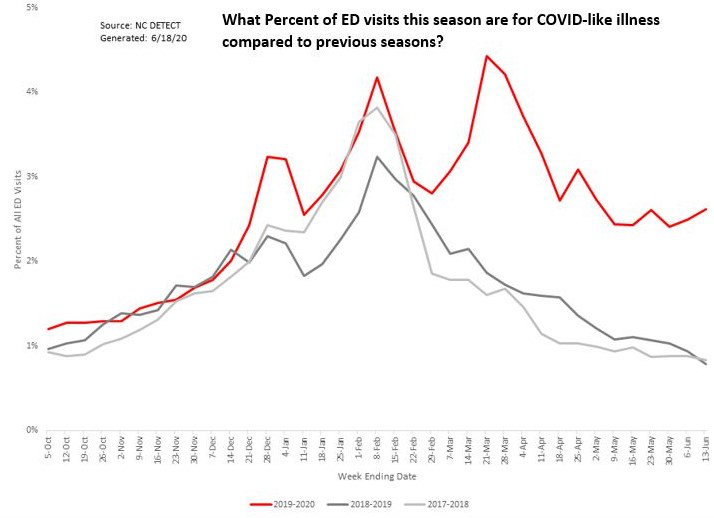

In [8]:
im = Image.open(requests.get('https://files.nc.gov/ncdhhs/images/covid19/dashboards/M_EDvisits_COVID.jpg', stream=True).raw)
im

##Hospitalizations
Is North Carolina seeing a 14 day downward trajectory or sustained leveling in the number of people currently hospitalized?

In [9]:
print(f'{hospitalized_max[1]}. The last peak was {hospitalized_max[2]} hospitalized patients on {hospitalized_max[3]}.')

No. The last peak was 883 hospitalized patients on Jun 20, 2020.


In [10]:
# Create figure
hospitalized_bar = go.Figure()

# Add bar chart and 14d moving average 
hospitalized_bar.add_trace(
    go.Bar(
        x=df['date'],
        y=df['hospitalizedCurrently'],
        name="Hospitalized"
    )
)
hospitalized_bar.add_trace(
    go.Scatter(
        x=df['date'],
        y=df['hospitalized_avg'],
        mode="lines",
        name="14d Moving Average"
    )
)

# Update title and height
hospitalized_bar.update_layout(
    title_text="Currently Hospitalized",
    yaxis_title="# of Patients",
    height=400,
    xaxis_range = ['2020-03-24', datetime.today()]
    )

hospitalized_bar.update_xaxes(rangeslider_visible=True) # Add rangeslider to X axis

hospitalized_bar

##New cases
Is North Carolina seeing a downward trajectory over 14 days, or sustained leveling in new cases?

In [11]:
print(f'{new_cases_max[1]}. The last peak was {new_cases_max[2]} new cases on {new_cases_max[3]}.')

No. The last peak was 1768 new cases on Jun 12, 2020.


In [12]:
# Create figure
new_cases_bar = go.Figure()

# Add bar chart and 14d moving average 
new_cases_bar.add_trace(
    go.Bar(
        x=df['date'],
        y=df['positiveIncrease'],
        name="New Cases"
    )
)
new_cases_bar.add_trace(
    go.Scatter(
        x=df['date'],
        y=df['new_case_avg'],
        mode="lines",
        name="14d Moving Average"
    )
)

# Update title and height
new_cases_bar.update_layout(
    title_text="New Covid-19 Cases",
    yaxis_title="# of Positive Tests",
    height=400,
    xaxis_range = ['2020-03-20', datetime.today()]
    )


new_cases_bar.update_xaxes(rangeslider_visible=True) # Add rangeslider to X axis

new_cases_bar

## Percent Positive Tests
Is North Carolina seeing a 14 day downward trajectory or sustained leveling of positive tests as a percentage of total tests?


In [13]:
find_max_date('percent_pos')

('green', 'Yes', 100, 'Mar 06, 2020')

In [14]:
# Create figure
percent_pos_bar = go.Figure()

# Add bar chart and 14d moving average 
percent_pos_bar.add_trace(
    go.Bar(
        x=df['date'],
        y=df['percent_pos'],
        name="Percent Positive Tests"
    )
)
percent_pos_bar.add_trace(
    go.Scatter(
        x=df['date'],
        y=df['avg_percent_pos'],
        mode="lines",
        name="14d Moving Average"
    )
)

# Update title and height
percent_pos_bar.update_layout(
    title_text="Positive Tests as a Percentage of Total",
    yaxis_title="% Positive Tests",
    height=400,
    xaxis_range = ['2020-04-21', datetime.today()],
    yaxis_range = [0, 20]
    )

percent_pos_bar.update_xaxes(rangeslider_visible=True) # Add rangeslider to X axis

percent_pos_bar

## Test Capacity
Does NC have the capacity to test an average of 5000 - 7000 people daily?

In [15]:
capacity_14d = df['avg_daily_tests'][-14:]
capacity_14d_bool = (capacity_14d < 5000).any()
capacity_14d_mean = round(capacity_14d.mean())
if capacity_14d_bool == True:
  print(f'No. Over the last 14 days only an average of {capacity_14d_mean} people were tested each day.')
else:
  print(f'Yes. Over the last 14 days an average of {capacity_14d_mean} people were tested each day.')

Yes. Over the last 14 days an average of 14714 people were tested each day.


In [16]:
# Create figure
daily_tests_bar = go.Figure()

# Add bar chart and 14d moving average 
daily_tests_bar.add_trace(
    go.Bar(
        x=df['date'],
        y=df['totalTestResultsIncrease'],
        name="Tests Completed"
    )
)
daily_tests_bar.add_trace(
    go.Scatter(
        x=df['date'],
        y=df['avg_daily_tests'],
        mode="lines",
        name="14d Moving Average"
    )
)

# Update title and height
daily_tests_bar.update_layout(
    title_text="Daily Tests Reported",
    yaxis_title="# of Tests",
    height=400,
    xaxis_range = ['2020-03-15', datetime.today()],
    )

daily_tests_bar.update_xaxes(rangeslider_visible=True) # Add rangeslider to X axis

daily_tests_bar